# Teacher Forcing in RNNs

**Roberto Fierimonte** - 19/02/2018

---

## Motivation and Goal:

### General:

* Recurrent Neural Nets (RNNs) model a conditional distribution over tokens:

$$ 
\newcommand{\given}{\,\big|\,}
p\left(y_1, y_2, \ldots, y_T\right) = p\left(y_1\right)\prod_{t=2}^T p\left(y_t\given y_1\,,\dots\,, y_{t−1}\right)\,
$$

* Maximum Likelihood (ML) training of RNNs is currently implemented using so-called "Teacher Forcing" (TF). Namely, we feed the ground-truth tokens $\mathbf{y}$ in the model to be conditioned on when generating the predicted outputs to be evaluated. If we don't do so, the sequence over which we condition on diverges from sequences seen during training and the errors can amplify exponentially

* In some domains the sequences available at training time are shorter than the sequences that we want to generate at test time. Also, for problems in which the goal is prediction of values that are farther in time, TF is an approximation

* When testing/performing inference, we don't feed the input sequence in the network, so at each time step the output is generated conditioning on the previous generated outputs (with the exception of the first token, which is usually some starting sequence identifier). This is inconsistent! 

* We refer to the mechanism opposed to TF as "Free Running". There are multiple variants of this approach used during inference, although usually only sampling is used during training:

    * **Sampling**: at each time step we use a sample $\hat{y}_t$ from $p\left(y_t\given \hat{y}_1\,,\dots\,, \hat{y}_{t−1}\right)$ and we add it to the conditioning set for $\hat{y}_{t+1}$
    <br>
    * **Greedy**: at each time step we select $\hat{y}_t = \arg\max_y p\left(y_t\given \hat{y}_1\,,\dots\,, \hat{y}_{t−1}\right)$
    <br>
    * **Beam search**: at each time step, we maintain a set of the $m$ "most promising" sentences. We expand each of them and we sort the results in term of joint probability. Finally we truncate them to retain those with higher probability

### Specific to our problem (VAEs for text modelling):

When generating a sentence $\mathbf{y}$ we condition on a sample of the latent variable $\mathbf{z}$, namely:

$$\log p\left(\mathbf{y}\given\mathbf{z};\theta\right) = \sum_{t=1}^T\log p\left(y_t\given y_1\,,\ldots\,,y_{t-1}, \mathbf{z};\theta\right)\,,
$$

where we have:

$$
\log p\left(y_t\given y_1\,,\ldots\,,y_{t-1}, \mathbf{z};\theta\right) = \log p\left(y_t\given h_t\right)\,
$$

and:

$$
h_t = 
\begin{cases} 
    f\left(\mathbf{z};\theta\right) & \text{if } t=1\\ 
    f\left(h_{t-1}, y_{t-1}; \theta\right) & \text{otherwise}\\
\end{cases}\,.
$$

The generation parameters $\theta$ are optimised using ML training over mini-batches:

$$
\theta^* = \arg\max_\theta \sum_{n=1}^N \log p\left(\mathbf{y}^n\given \mathbf{z}^n;\theta\right)\,.
$$

* Currently we use teacher forcing to train the langauge model. This makes the entire model too powerful to meaningfully use latents - needs for KL annealing and word drop procedures:

    * KL annealing is implemented by gradually turning on the KL term in the ELBO during training (tackled by AutoGen training)
    * Word drop is implemented by randomly dropping randomly and replacing some fraction of the conditioned-on word tokens with the generic unknown word token `<UNK>`

* We consider the use of these procedures an artifact that invalidates the performance of the model itself

Teacher-forcing affects the problem of Natural Language generation in more than one way: 

1. Textual data is naturally sparse. As soon as the conditional generation implemented using sampling mode deviates from a known sequence, the entire generation diverges

2. For the same reason, when generating a text using TF, the latents are barely used (conditioning on the latents is barely helpful when the next word is well-specified by the sequence of the preceeding ones)

We remark that image generation models (e.g. PixelRNN) are not reported to use this procedure while training (plus, they can use latents pretty well). We argue that this is due to the use of only local information in the generative model (so that the latents can contribute to capturing the global context)

## State of the Art:

### Teacher Forcing (Williams and Zipser, 1989)

What we have described above, with all the positive and negative aspects.

### Curriculum Learning (Bengio et al., 2015)

The training process is re-designed in order to **gradually** force the model to deal with its own mistakes, as it would have to during inference.

During training, at every time step $t$ we flip a biased coin. With probability $\epsilon_t$ we use a token from the ground-truth $\mathbf{y}$ (teacher forcing) and with probability $1 - \epsilon_t$ we use the previously generated token $\hat{y}_{t-1}$ (sampling mode).

<figure>
    <img src="./scheduled-sampling.png" width="500" />
</figure>    

Two extremes:
1. $\epsilon_t = 1\,\forall t$ is the teacher forcing approach
2. $\epsilon_t = 0\,\forall t$ is the sampling mode approach

Idea: annealing $\epsilon_t$ over time steps (**scheduled sampling**). Three options:

1. Linear decay: $\epsilon_t = \max\left(\epsilon, k − c\cdot t\right)$, with $\epsilon \in (0,1)$, $k$ and $c$ parameters
2. Exponential decay: $\epsilon_t = k^t$, with $k < 1$ parameter 
3. Inverse sigmoid decay: $\epsilon_t = \dfrac{k}{k + \exp\left(\dfrac{t}{k}\right)}$, with $k\geq 1$ parameter

No error is back-propagated when samples $\hat{y}_{t}$ are used for conditional generation. Sampling the previous token leads to a stochastic node in the computational graph for which the gradient cannot be computed directly. Will come to this point later.

Without back-propagating the gradient through the samples the results of training are likely to be strongly degraded (and actually they are).

### Professor Forcing (Goyal et al., 2016)

**Adversarial approach**: a pair of twin RNNs (with shared parameters $\theta_g$) output sentences using teacher forcing and sampling mode respectively. A **classifier** discriminates if the hidden states are generated by the first network or by the second one.

<figure>
    <img src="./professor-forcing.jpg" width="600" />
</figure>

The classifier/discriminator is a Bidirectional RNN with parameters $\theta_d$ trained to maximise the likelihood of
correctly classifying a behaviour sequence (chosen hidden states and output values):

$$
\min_{\theta_d}\mathbb{E}_{(x, y)\sim \text{data}}\left[− \log D\left(B\left(x, y; \theta_g\right); \theta_d\right)\right] + \mathbb{E}_{x\sim\text{data}, y\sim p_{\theta_g}\left(y| x\right)}
\left[− \log \left(1 − D\left( B \left(x, y; \theta_g\right); \theta_d\right)\right)\right]\,,
$$

where $D\left(\mathbf{s}\right)$ is the discriminator function (i.e. the probability that the sequence $\mathbf{s}$ is produced in teacher forcing mode) and $B$ is the behaviour sequence generator. The first term corresponds to the TF case while the second term corresponds to the sampling mode. Please notice that in our case, since we do not have different inputs/outputs, in the first term we simply have $x = y$.

The two hidden layers of the discriminator (forward and backward RNN) are then concatenated at each time step and passed through a MLP, which outputs the discriminator function $D\left(\cdot\right)$.

The generator is an RNN trained to maximise the likelihood of the data and contextually fool the discriminator:

$$
\min_{\theta_g}\mathbb{E}_{(x,y)\sim\text{data}}\left[− \log p_{\theta_g}\left(y\given x\right)\right]
+
 \mathbb{E}_{x\sim\text{data}, y\sim p_{\theta_g}\left(y|x\right)}
\left[− \log D\left(B\left(x, y; \theta_g\right); \theta_d\right)\right]\,,
$$

where the first term is the negative log-likelihood (NLL) and the second term aims at maximising the probability of the sampling mode behaviour such that it matches the teacher force behaviour.

Eventually we can ask the teacher force behavior to be indistinguishable from the sampling mode behavior:

$$
\mathbb{E}_{(x,y)\sim\text{data}}\left[− \log\left(1 − D\left(B\left(x, y; \theta_g\right); \theta_d\right)\right)\right].
$$

Practically, this is achieved with a variant of stochastic gradient descent with minibatches formed by combining $N$ sequences obtained in teacher forcing mode and $N$ sequences obtained in sampling mode.

### Categorical Reparametrisation with Gumbel-Softmax (Jang et al., 2017)

In the Curriculum Learning approach, there is no gradient back-propagated when the previous samples are used for conditional generation in the RNN (due to the stochasticity of the operation). This approach badly affect learning performance. We can overcome this problem by using a reparametrisation of the categorical distribution (equivalent concept of the Gaussian reparametrisation trick in VAEs).

The Gumbel-Max trick (Gumbel, 1954) provides a way to draw samples $z$ from a categorical distribution with class probabilities $\pi$:

$$z = \text{one hot}\left(\arg \max_i\left[g_i + \log \pi_i\right]\right)\,,$$

where $g_1,\,\ldots\,,g_k$ are i.i.d samples drawn from the $\text{Gumbel}(0, 1)$ distribution. 

$$
g_1,\,\ldots\,,g_k \sim \exp\left\{-\left(g + \exp\{-g\}\right)\right\}\,.
$$

Approximate samples $y$ are obtained by replacing the non-differentiable $\arg \max$ with a softmax function, returning:

$$y_i = \dfrac{\exp\left(g_i + \log \pi_i\right)/\tau}{\sum_{j=1}^k \exp\left(g_j + \log \pi_j\right)/\tau}\,\forall i=1,\,\ldots,\,k\,.$$

$\tau$ is a temperature parameter. For learning, there is a tradeoff between small temperatures, where samples are close to one-hot but the variance of the gradients is large, and large temperatures, where samples are smooth but the variance of the gradients is small [cit].

<img src="./gumbel-softmax.png" width="600" />

The Gumbel-Softmax distribution is smooth for $\tau > 0$, and therefore has a well-defined gradient with respect to $\pi$. Thus, by replacing categorical samples with Gumbel-Softmax samples we can use backpropagation to compute the gradients with respect to the sampled words in an RNN trained without teacher-forcing.

Notice that in the derivation of the samples $y_i$ we have used a continuous softmax function. If we want samples to be discrete (like in our case) we still apply the $\arg \max$ operator to $y_i$, but the gradient is approximated as: $$\nabla_\theta z \approx \nabla_\theta y\,.$$ In this case the estimator is known as Straight Trought (ST) Gumbel-Softmax.

## Considerations and Next Steps:

We argue that TF, despite the help provided during the training phase, is not a useful way to train a generative model for text if our objective is to incorporate meaningful latents. On the other side, pure training without TF leads to instability and low performance (experiments are in progress).

Removing the TF procedure has been already found useful for other problems, and different solution has been proposed to solve the problem. A good initial result would be to remove the need for the word drop procedure in text-VAE. We also expect the role of the latents to change.

The immediate next steps are:

Short term:
* Run experiment without TF and without any alternative algorithm
* Run experiment using sampling mode on top of the results learned using TF (hard version of CL that completely switches off TF after a fixed iteration)
* Run experiment using alternative algorithms (in particular CL and ST Gumbel-Softmax are easier to implement) 

Long term:
* Re-formulate the problem in a way that sparsness of the data + training do not degrade the role of the latents

In [3]:
import datetime
import functools
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline 

tfd = tf.contrib.distributions
tfb = tf.contrib.bayesflow

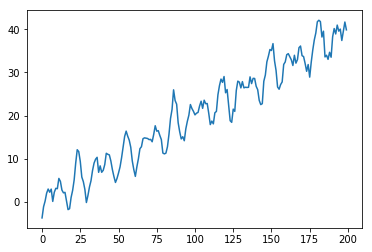

In [38]:
time = np.arange(0, 200)
sigma = 1
y = 0.2 * time + 3 * np.sin(0.6 * time) - 3 * np.cos(0.4 * time) #+ 1e-5 * time # - 5e-3 * (time - 40) ** 2
y_tilde = y + sigma * np.random.randn(len(time))
plt.plot(y_tilde)
# plt.plot(y, 'r')
ts = y_tilde

In [39]:
def doublewrap(function):
    """
    A decorator decorator, allowing to use the decorator to be used without
    parentheses if not arguments are provided. All arguments must be optional.
    """
    @functools.wraps(function)
    def decorator(*args, **kwargs):
        if len(args) == 1 and len(kwargs) == 0 and callable(args[0]):
            return function(args[0])
        else:
            return lambda wrapee: function(wrapee, *args, **kwargs)
    return decorator


@doublewrap
def define_scope(function, scope=None, *args, **kwargs):
    """
    A decorator for functions that define TensorFlow operations. The wrapped
    function will only be executed once. Subsequent calls to it will directly
    return the result so that operations are added to the graph only once.
    The operations added by the function live within a tf.variable_scope(). If
    this decorator is used with arguments, they will be forwarded to the
    variable scope. The scope name defaults to the name of the wrapped
    function.
    """
    attribute = '_cache_' + function.__name__
    name = scope or function.__name__
    @property
    @functools.wraps(function)
    def decorator(self):
        if not hasattr(self, attribute):
            with tf.variable_scope(name, *args, **kwargs):
                setattr(self, attribute, function(self))
        return getattr(self, attribute)
    return decorator

In [53]:
class SimpleSamplingCell(tf.contrib.rnn.RNNCell):
    """
    """
    def __init__(self, cell, output_size, layer, reuse=None):
        super(SimpleSamplingCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._output_size = output_size
        self._layer = layer

    @property
    def state_size(self):
        return (self._cell.state_size, self._output_size)

    @property
    def output_size(self):
        return (self._output_size)
    
    def call(self, inputs, state_and_sample):
        del inputs  # Unused.
        (state, sample) = state_and_sample
        out, state = self._cell(sample, state)
        sample = self._layer(out)
        return sample, (state, sample)
    
class BaselineModel(object):
    """
    """
    def __init__(self, cell_type='GRU', n_hidden=100):
        self._n_hidden = n_hidden
        self._layer = tf.layers.Dense(1)
        self._cell_type = cell_type
        if cell_type == 'GRU':
            self._cell = tf.contrib.rnn.GRUBlockCell(self._n_hidden)
        elif cell_type == 'LSTM':
            self._cell = tf.contrib.rnn.LSTMBlockCell(self._n_hidden)
        elif cell_type == 'RNN':
            self._cell = tf.contrib.rnn.BasicRNNCell(self._n_hidden)
        self._sampling_cell = SimpleSamplingCell(self._cell, 1, self._layer)

    def compute_forward(self, data):
        (out, hidden) = tf.nn.dynamic_rnn(self._cell, inputs=data, dtype=tf.float32)
        res = self._layer(out)
        return res, hidden    
    
    def pred_forward(self, data, last_training_point, last_hidden):
        inputs = tf.concat([last_training_point[:, None], data], 1)        
        (out, _) = tf.nn.dynamic_rnn(self._cell, inputs=inputs, initial_state=last_hidden, dtype=tf.float32)
        res = self._layer(out)
        return res
    
    def pred_forward_autoregressive(self, last_training_point, last_hidden, future=500):
        sample = last_training_point
        hidden = last_hidden
        samples = []
        
        for _ in range(future):
            (out, hidden) = self._cell(sample, hidden)
            sample = self._layer(out)
            samples.append(sample)
            
        return tf.transpose(tf.stack(samples, 0), [1,0,2])

In [81]:
tf.reset_default_graph()

seq_length = 50; cell_type = 'RNN'; n_hidden = 50
x_ = tf.placeholder(tf.float32, [None, None, 1])
x_test = tf.placeholder(tf.float32, [None, seq_length, 1])

with tf.variable_scope(cell_type + '_' + str(n_hidden), reuse=tf.AUTO_REUSE) as scope:
    model = BaselineModel(cell_type, n_hidden)
    res, hidden = model.compute_forward(x_[:, :-1])
    loss = tf.reduce_mean(tf.reduce_sum(tf.square(res[..., 0] - x_[:, 1:, 0]), 1))/2
    optimise = tf.train.AdamOptimizer(0.001).minimize(loss)
    
    pred_tf = model.pred_forward(x_test, x_[:, -1], hidden)
    pred_ar_tf = model.pred_forward_autoregressive(x_[:, -1], hidden, future=50)

config = tf.ConfigProto(allow_soft_placement=True)
sess = tf.InteractiveSession(config=config) 
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
errors_baseline = []; preds_baseline = []; preds_baseline_ar = []; errors_test_baseline = []

timestamp = datetime.datetime.strftime(datetime.datetime.now(), "%Y-%m-%d_%H:%M")

for i in range(10001):
    batch = np.stack([ts[i:i+50] for i in np.random.randint(0, 150, 10)])    
    error = sess.run(loss, {x_: batch[..., None]})
    sess.run(optimise, {x_: batch[..., None]})
    errors_baseline.append(error)
    
    if i % 1000 == 0:
        test_batch = ts[150:200]
        test_error = sess.run(loss, {x_: test_batch[None, :, None]})
        errors_test_baseline.append(test_error)
        print('Iteration:', i, 'Training Error:', error, 'Test Error:', test_error)
        pred = sess.run(pred_tf, {x_: ts[None, :150, None], x_test: ts[None, 150:, None]})
        pred_ar = sess.run(pred_ar_tf, {x_: ts[None, :150, None]})
        preds_baseline.append(pred); preds_baseline_ar.append(pred_ar)
        
save_path = saver.save(sess, "/mnt/workspace/baseline_{}_length_{}_iter_{}.ckpt".format(timestamp, seq_length, i))

Iteration: 0 Training Error: 9277.5 Test Error: 27351.9
Iteration: 1000 Training Error: 203.883 Test Error: 1361.99
Iteration: 2000 Training Error: 35.1022 Test Error: 394.712
Iteration: 3000 Training Error: 35.4197 Test Error: 220.285
Iteration: 4000 Training Error: 29.6018 Test Error: 156.262
Iteration: 5000 Training Error: 31.6098 Test Error: 120.995
Iteration: 6000 Training Error: 25.416 Test Error: 94.0751
Iteration: 7000 Training Error: 20.2881 Test Error: 93.2321
Iteration: 8000 Training Error: 22.9452 Test Error: 95.8232
Iteration: 9000 Training Error: 10.5315 Test Error: 85.2635
Iteration: 10000 Training Error: 15.3209 Test Error: 85.0436


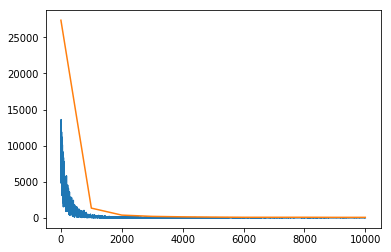

In [95]:
plt.plot(errors_baseline)
plt.plot(range(0, 10001, 1000), errors_test_baseline)

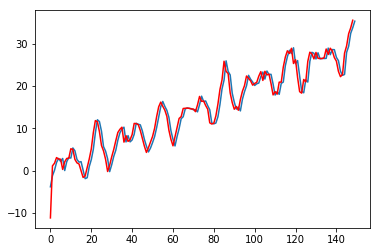

In [82]:
fit = sess.run(res, {x_: ts[None, :150, None]})
plt.plot(ts[None, :150].T)
plt.plot(fit[..., 0].T, 'r')

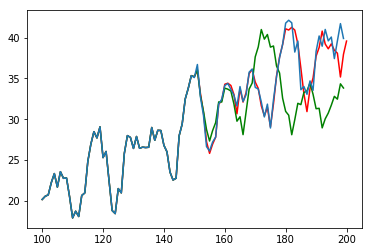

In [93]:
plt.plot(range(100, 201), np.concatenate([ts[None, 100:150, None], pred], 1)[0], 'r')
plt.plot(range(100, 200), np.concatenate([ts[None, 100:150, None], pred_ar], 1)[0], 'g-')
plt.plot(range(100, 200), ts[None, 100:200].T)

In [ ]:
tf.reset_default_graph()

seq_length = 1000
x_ = tf.placeholder(tf.float32, [1, None])

model = RobustARGenerator(x_, 'GRU', n_hidden=100, n_samples=200, seq_length=seq_length, n_pred_forward=1000)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.restore(sess, '/mnt/workspace/sin_2018-04-07_10:59_length_1000_iter_30000.ckpt')

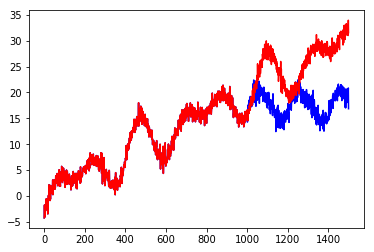

In [46]:
pred = sess.run(model.predict_forward, {x_: ts[:seq_length, None].T})
for i in range(1):
    plt.plot(np.concatenate([ts[:seq_length], pred[i][:500]]), 'b')
plt.plot(np.concatenate([ts[:seq_length], ts[seq_length:seq_length+500]]), 'r')

In [302]:
class GaussianCell(tf.contrib.rnn.RNNCell):
    """
    RNN cell that outputs mean and standard deviation at every step
    """
    def __init__(self, cell, event_size, reuse=None):
        super(GaussianCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._event_size = event_size

    @property
    def state_size(self):
        return self._cell.state_size

    @property
    def output_size(self):
        return (self._event_size, self._event_size)

    def call(self, inputs, state):
        hidden, state = self._cell(inputs, state)
        mean = tf.layers.dense(hidden, self._event_size)
        std = tf.layers.dense(hidden, self._event_size, tf.nn.softplus)
        return (mean, std), state

    
class SamplingCell(tf.contrib.rnn.RNNCell):
    """
    RNN cell that produce a sequence in autoregressive mode by sampling at 
    each step
    """
    def __init__(self, cell, output_size, reuse=None):
        super(SamplingCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._output_size = output_size

    @property
    def state_size(self):
        return (self._cell.state_size, self._output_size)

    @property
    def output_size(self):
        return (self._output_size, self._output_size)
    
    def call(self, inputs, state_and_sample):
        del inputs  # Unused.
        (state, sample) = state_and_sample
        (mean, std), state = self._cell(sample, state)
        sample = tfd.Normal(mean, std).sample()
        return (mean, std), (state, sample)
        
class RobustARGenerator(object):
    """
    Model to test
    """
    def __init__(self, data, n_hidden=100, n_samples=200, seq_length=1000):
        self._data = data
        self._n_hidden = n_hidden
        self._n_samples = n_samples
        self._seq_length = seq_length
        
        self._cell = tf.contrib.rnn.BasicRNNCell(self._n_hidden)               
        self._gaussian_cell = GaussianCell(self._cell, 1)
        self._sampling_cell = SamplingCell(self._gaussian_cell, 1)
        
        self._optimiser = tf.train.AdamOptimizer(0.001)
        
        self._gen_stddev = tf.nn.softplus(tf.get_variable('generative_std', shape=(), 
                                                          initializer=tf.constant_initializer(10)))
        self._post_stddev = tf.nn.softplus(tf.get_variable('posterior_std', shape=(), 
                                                           initializer=tf.constant_initializer(10)))
        self.compute_elbo
        self.optimise
        self.E_step
        self.M_step
    
    @define_scope
    def make_posterior(self):
        return tfd.MultivariateNormalDiag(self._data[0], scale_identity_multiplier=self._post_stddev)
    
    @define_scope
    def make_transitional(self):
        initial_state = tf.zeros_like(tf.tile(self._data[:, 0], [self._n_samples, self._n_hidden]))
        
        all_means = []; all_stds = []
        inputs = tf.concat([tf.zeros((self._n_samples, 1, 1)), self._code[:, :-1]], 1)
        initial_state = tf.zeros((self._n_samples, self._n_hidden))
        (means, stds), _ = tf.nn.dynamic_rnn(self._gaussian_cell, inputs, dtype=tf.float32,
                                             initial_state=initial_state)
        return means, stds
        
#         for i in range(self._n_samples):
# #             inputs = tf.concat([tf.zeros_like(self._code)[0, :, -1, None], self._code[i, :, :-1]], 1)
# #             initial_state = tf.zeros_like(tf.tile(self._data[:, 0], [1, self._n_hidden]))
# #             (means, stds), _ = tf.nn.dynamic_rnn(self._gaussian_cell, inputs, dtype=tf.float32,
# #                                              initial_state=initial_state)
            
#             (means, stds), _ = tf.nn.dynamic_rnn(self._sampling_cell, tf.zeros_like(self._code)[0, :, :], 
#                                      initial_state=(tf.zeros_like(tf.tile(self._data[:, 0], [1, self._n_hidden])), 
#                                                     tf.zeros_like(self._data[:, 0])), dtype=tf.float32)
#             all_means.append(means); all_stds.append(stds)
            
#         return tf.stack(all_means, 0), tf.stack(all_stds, 0)
    
    @define_scope
    def compute_elbo(self):
        posterior = self.make_posterior
        self._code = posterior.sample((self._n_samples))
        
        exponent_gen = tf.square(self._code - self._data)/(2 * tf.square(self._gen_stddev))
        norm_constant_gen = tf.sqrt(2 * np.pi * tf.square(self._gen_stddev))
        likelihood = tf.reduce_sum(tf.reduce_mean(-exponent_gen[..., 0] - tf.log(norm_constant_gen), 0))
        
        means, stddevs = self.make_transitional
        exponent_trans = (self._code - means)/(2 * tf.square(stddevs))
        norm_constant_trans = tf.sqrt(2 * np.pi * tf.square(stddevs))
        log_prob_trans = - tf.log(norm_constant_trans) - exponent_trans
        
        exponent_post = tf.square(self._code - self._data)/(2 * tf.square(self._post_stddev))
        norm_constant_post = tf.sqrt(2 * np.pi * tf.square(self._post_stddev))
        log_prob_post = - tf.log(norm_constant_post) - exponent_post
        
        kl = tf.reduce_sum(tf.reduce_mean(log_prob_post - log_prob_trans, 0))
        
        return likelihood - kl, kl, likelihood
    
    @define_scope
    def E_step(self):
        post_var = [v for v in tf.trainable_variables() if v.name.startswith('posterior_std')]
        return self._optimiser.minimize(-self.compute_elbo[0], var_list=post_var)
    
    @define_scope
    def M_step(self):
        non_post_var = [v for v in tf.trainable_variables() if not v.name.startswith('posterior_std')]
        return self._optimiser.minimize(-self.compute_elbo[0], var_list=non_post_var)
    
    @define_scope
    def optimise(self):
        return self._optimiser.minimize(-self.compute_elbo[0])

In [305]:
tf.reset_default_graph()

seq_length = 150; cell_type = 'RNN'; n_hidden = 50
x_ = tf.placeholder(tf.float32, [None, seq_length, 1])
gen_model = RobustARGenerator(x_, n_hidden=50, n_samples=100, seq_length=seq_length)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

elbos = []; kls = []; llks = []; test_elbos = []; preds = []; preds_greedy = []

for i in range(15001):
    batch = ts[:150][None, ...]
#     batch = np.stack([ts[i:i+50] for i in np.random.randint(0, 150, 1)])
    elbo, kl, llk = sess.run(gen_model.compute_elbo, {x_: batch[..., None]})
    elbos.append(elbo); kls.append(kl); llks.append(llk)
    
    sess.run(gen_model.E_step, {x_: batch[..., None]})
    sess.run(gen_model.M_step, {x_: batch[..., None]})
    
    if i % 10 == 0:
#         test_batch = ts[150:200]
#         test_elbo = sess.run(gen_model.compute_elbo[0], {x_: test_batch[None, :, None]})
#         test_elbos.append(test_elbos)
        print('Iteration:', i, 'ELBO:', elbo, 'KL:', kl, 'LLK:', llk) #, 'Test ELBO:', test_elbo)

Iteration: 0 ELBO: -3330.13 KL: 2771.9 LLK: -558.228
Iteration: 10 ELBO: -1118.89 KL: 561.794 LLK: -557.093
Iteration: 20 ELBO: -753.019 KL: 193.872 LLK: -559.147
Iteration: 30 ELBO: -615.163 KL: 58.7856 LLK: -556.378
Iteration: 40 ELBO: -589.075 KL: 30.8645 LLK: -558.211
Iteration: 50 ELBO: -548.815 KL: -5.27174 LLK: -554.087
Iteration: 60 ELBO: -530.37 KL: -27.6931 LLK: -558.063
Iteration: 70 ELBO: -478.552 KL: -78.0888 LLK: -556.641
Iteration: 80 ELBO: -458.912 KL: -98.011 LLK: -556.923


KeyboardInterrupt: 

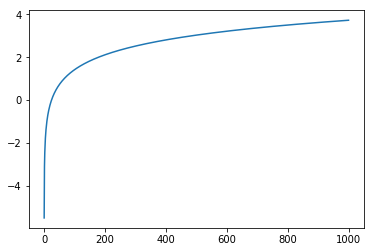

In [260]:
plt.plot([np.log(sigma * np.sqrt(2*np.pi*np.e)) for sigma in np.arange(0.001, 10, 0.01)])

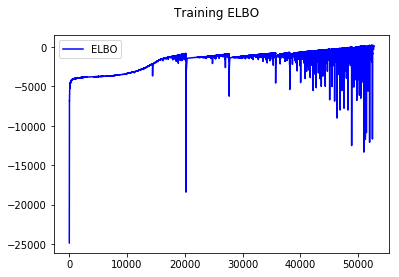

In [9]:
plt.plot(elbos[10:], 'b', label='ELBO')
# plt.plot(kls, 'g', label='KL')
# plt.plot(llks, 'orange', label='LLK')
plt.suptitle('Training ELBO')
plt.legend()
plt.show()

In [ ]:
(out, H) = sess.run(model.make_joint_posterior, {x_: aapl[:seq_length, None].T})

In [10]:
sess.run(model._gen_stddev, {x_: ts[:seq_length, None].T})

array([ 0.00064722], dtype=float32)

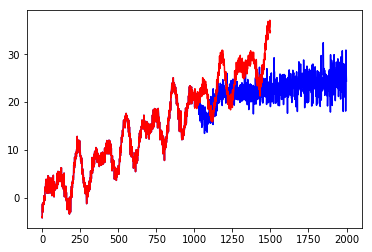

In [22]:
pred = sess.run(model.predict_forward, {x_: ts[:seq_length, None].T})
for i in range(1):
    plt.plot(np.concatenate([ts[:seq_length], pred[i]]), 'b')
plt.plot(np.concatenate([ts[:seq_length], ts[seq_length:seq_length+500]]), 'r')

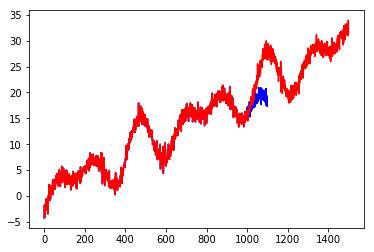

In [35]:
pred = sess.run(model.predict_forward, {x_: ts[:seq_length, None].T})
for i in range(1):
    plt.plot(np.concatenate([ts[:seq_length], pred[i][:500]]), 'b')
plt.plot(np.concatenate([ts[:seq_length], ts[seq_length:seq_length+500]]), 'r')

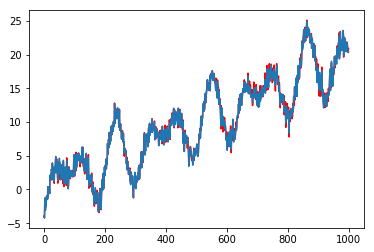

In [12]:
m, s = sess.run(model.make_transitional, {x_: ts[:seq_length, None].T})
plt.plot(ts[:seq_length], 'r')
plt.plot(m[0, :, 0])

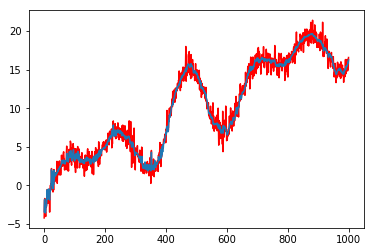

In [36]:
m, s = sess.run(model.make_transitional, {x_: ts[:seq_length, None].T})
plt.plot(ts[:seq_length], 'r')
plt.plot(m[0, :, 0])

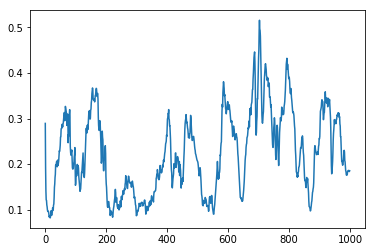

In [13]:
plt.plot(s[0, :, 0])

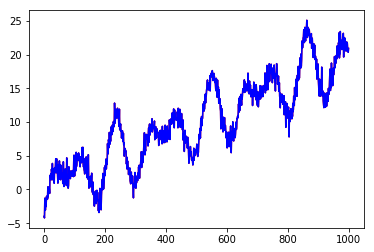

In [14]:
plt.plot(ts[:seq_length], 'r', test_latents[0, :, 0], 'b')

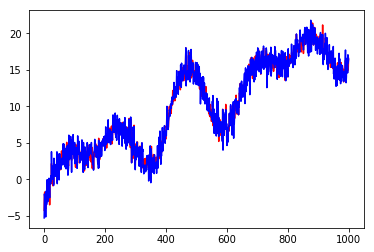

In [48]:
plt.plot(ts[:seq_length], 'r', test_latents[0, :, 0], 'b')